In [16]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import MonthEnd

import datetime
import feather

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [9]:
# read data

def my_date_parser(x):
    """ Parse date and handle missing date too"""
    try:
        return pd.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p')
    except:
        return pd.NaT

    
df_seattle = pd.read_csv('Seattle_Police_Department_Police_Report_Incident.csv', sep=';', 
                         parse_dates=["Occurred Date or Date Range Start", "Occurred Date Range End"], 
                         na_values=['NaN','nan'],
                         date_parser=my_date_parser)

df_sanfrancisco = pd.read_csv('_Change_Notice__Police_Department_Incidents.csv', sep=';',
                         na_values=['NaN','nan'])

df_seattle['datetime'] = df_seattle['Occurred Date or Date Range Start']
df_sanfrancisco['datetime'] = pd.to_datetime(df_sanfrancisco['Date'] + ' ' + df_sanfrancisco['Time'])



df_seattle = df_seattle[df_seattle.datetime.dt.year == 2017]
df_sanfrancisco = df_sanfrancisco[df_sanfrancisco.datetime.dt.year == 2017]
print(len(df_seattle))
print(len(df_sanfrancisco))

feather.write_dataframe(df_seattle, 'seattle_2017.feather')
feather.write_dataframe(df_sanfrancisco, 'sanfrancisco_2017.feather')

228018
154773


TypeError: write_feather() missing 2 required positional arguments: 'df' and 'dest'

In [186]:
df_seattle = feather.read_dataframe('seattle_2017.feather')
df_sanfrancisco = feather.read_dataframe('sanfrancisco_2017.feather')

In [187]:
df_sanfrancisco.rename({'Category': 'offense_raw'}, axis='columns', inplace='True')
df_seattle.rename({'Summarized Offense Description': 'offense_raw'}, axis='columns', inplace=True)

In [188]:
sfo_crimes = set( df_sanfrancisco.offense_raw.unique() )
seattle_crimes = set( df_seattle.offense_raw.unique() )
print('SFO\n', sorted(sfo_crimes), len(sfo_crimes), '\nSEATTLE\n', sorted(seattle_crimes), len(seattle_crimes))

SFO
 ['ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY', 'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE', 'DRUG/NARCOTIC', 'DRUNKENNESS', 'EMBEZZLEMENT', 'EXTORTION', 'FAMILY OFFENSES', 'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING', 'KIDNAPPING', 'LARCENY/THEFT', 'LIQUOR LAWS', 'LOITERING', 'MISSING PERSON', 'NON-CRIMINAL', 'OTHER OFFENSES', 'PORNOGRAPHY/OBSCENE MAT', 'PROSTITUTION', 'RECOVERED VEHICLE', 'ROBBERY', 'RUNAWAY', 'SECONDARY CODES', 'SEX OFFENSES, FORCIBLE', 'SEX OFFENSES, NON FORCIBLE', 'STOLEN PROPERTY', 'SUICIDE', 'SUSPICIOUS OCC', 'TREA', 'TRESPASS', 'VANDALISM', 'VEHICLE THEFT', 'WARRANTS', 'WEAPON LAWS'] 39 
SEATTLE
 ['ANIMAL COMPLAINT', 'ASSAULT', 'BIAS INCIDENT', 'BIKE THEFT', 'BURGLARY', 'BURGLARY-SECURE PARKING-RES', 'CAR PROWL', 'COUNTERFEIT', 'DISORDERLY CONDUCT', 'DISPUTE', 'DISTURBANCE', 'DUI', 'ELUDING', 'EMBEZZLE', 'ESCAPE', 'EXTORTION', 'FALSE REPORT', 'FIREWORK', 'FORGERY', 'FRAUD', 'HARBOR CALLS', 'HARBOR CALLs', 'HOMICIDE', 'ILLEGAL DUMPING', '

In [189]:
# fix typos
df_seattle['offense_raw'] = df_seattle.offense_raw.str.upper()

In [190]:
# remove 
ds = ['LOST PROPERTY', 'NON-CRIMINAL', 'SUICIDE', 'RECOVERED PROPERTY', 'INJURY', 'MISSING PERSON', 'FALSE REPORT']
for d in ds:
    if d in df_sanfrancisco.offense_raw.unique():
        df_sanfrancisco = df_sanfrancisco[~df_sanfrancisco.offense_raw.isin([d])]
    if d in df_seattle.offense_raw.unique():
        df_seattle = df_seattle[~df_seattle.offense_raw.isin([d])]


In [191]:
print(len(set( df_sanfrancisco.offense_raw.unique())))
print(len(set( df_seattle.offense_raw.unique())))

36
49


In [192]:
# try to pair siminlar offenses between SFO and Seattle
# cleanup offense cols
def mapper(a, b):
    """seattle, sfo -> keep sfo"""
    # map from seattle to sfo
    equiv = [["LIQUOR VIOLATION", "LIQUOR LAWS"],
             ["RECKLESS BURNING", "ARSON"],
             ["WEAPON", "WEAPON LAWS"],
             ["GAMBLE", "GAMBLING"],
             ["LIQUOR VIOLATION", "DRUNKENNESS"],
             ["DRIVING UNDER THE INFLUENCE", "DUI"],
             ["ELUDING", "ESCAPE"],
             ["WARRANT ARREST", "WARRANTS"],
             [["FRAUD", "BAD CHECKS", "EMBEZZLE"], "FRAUD AND FINANCIAL"],
             [["FORGERY/COUNTERFEITING", "COUNTERFEIT"], "FORGERY"],
             ["NARCOTICS", "DRUG/NARCOTIC"],
             ["PROPERTY DAMAGE", "VANDALISM"],
             ["FAMILY OFFENSES", "DOMESTIC VIOLENCE"],
             ["PORNOGRAPHY" , "PORNOGRAPHY/OBSCENE MAT"],
             ["BURGLARY", "BURGLARY-SECURE PARKING-RES"],
             
            ]

    # build replace dict
    md = {}
    for e in equiv:
        if type(e[0]) == list:
            for j in e[0]:
                md[j] = e[1]
        else:
            md[e[1]] = e[0]

    print(md)

    a['offense'] = a.offense_raw.map(md).fillna(a.offense_raw)
    b['offense'] = b.offense_raw.map(md).fillna(b.offense_raw)
    return (a, b)

df_seattle2, df_sanfrancisco2 = mapper(df_seattle, df_sanfrancisco)
df_sanfrancisco2.head(2)

{'LIQUOR LAWS': 'LIQUOR VIOLATION', 'ARSON': 'RECKLESS BURNING', 'WEAPON LAWS': 'WEAPON', 'GAMBLING': 'GAMBLE', 'DRUNKENNESS': 'LIQUOR VIOLATION', 'DUI': 'DRIVING UNDER THE INFLUENCE', 'ESCAPE': 'ELUDING', 'WARRANTS': 'WARRANT ARREST', 'FRAUD': 'FRAUD AND FINANCIAL', 'BAD CHECKS': 'FRAUD AND FINANCIAL', 'EMBEZZLE': 'FRAUD AND FINANCIAL', 'FORGERY/COUNTERFEITING': 'FORGERY', 'COUNTERFEIT': 'FORGERY', 'DRUG/NARCOTIC': 'NARCOTICS', 'VANDALISM': 'PROPERTY DAMAGE', 'DOMESTIC VIOLENCE': 'FAMILY OFFENSES', 'PORNOGRAPHY/OBSCENE MAT': 'PORNOGRAPHY', 'BURGLARY-SECURE PARKING-RES': 'BURGLARY'}


,IncidntNum,offense_raw,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,datetime,offense
0,171040533,OTHER OFFENSES,PROBATION VIOLATION,Monday,12/25/2017,20:32,TENDERLOIN,"ARREST, BOOKED",100 Block of HYDE ST,-122.415670,37.782120,"(37.78211984889314, -122.41566966144342)",17104053326170,2017-12-25 20:32:00,OTHER OFFENSES
1,171040561,ASSAULT,AGGRAVATED ASSAULT WITH A DEADLY WEAPON,Monday,12/25/2017,19:55,MISSION,"ARREST, BOOKED",500 Block of SOUTH VAN NESS AV,-122.417477,37.764358,"(37.76435775168604, -122.41747701285014)",17104056104013,2017-12-25 19:55:00,ASSAULT


In [193]:
sfo_crimes2 = set( df_sanfrancisco2.offense.unique() )
seattle_crimes2 = set( df_seattle2.offense.unique() )
print(sorted(sfo_crimes2), len(sfo_crimes2), '\n', sorted(seattle_crimes2), len(seattle_crimes2))

['ASSAULT', 'BRIBERY', 'BURGLARY', 'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE', 'EMBEZZLEMENT', 'EXTORTION', 'FAMILY OFFENSES', 'FORGERY', 'FRAUD AND FINANCIAL', 'GAMBLE', 'KIDNAPPING', 'LARCENY/THEFT', 'LIQUOR VIOLATION', 'LOITERING', 'NARCOTICS', 'OTHER OFFENSES', 'PORNOGRAPHY', 'PROPERTY DAMAGE', 'PROSTITUTION', 'RECKLESS BURNING', 'RECOVERED VEHICLE', 'ROBBERY', 'RUNAWAY', 'SECONDARY CODES', 'SEX OFFENSES, FORCIBLE', 'SEX OFFENSES, NON FORCIBLE', 'STOLEN PROPERTY', 'SUSPICIOUS OCC', 'TREA', 'TRESPASS', 'VEHICLE THEFT', 'WARRANT ARREST', 'WEAPON'] 34 
 ['ANIMAL COMPLAINT', 'ASSAULT', 'BIAS INCIDENT', 'BIKE THEFT', 'BURGLARY', 'CAR PROWL', 'DISORDERLY CONDUCT', 'DISPUTE', 'DISTURBANCE', 'DRIVING UNDER THE INFLUENCE', 'ELUDING', 'EXTORTION', 'FIREWORK', 'FORGERY', 'FRAUD AND FINANCIAL', 'HARBOR CALLS', 'HOMICIDE', 'ILLEGAL DUMPING', 'LIQUOR VIOLATION', 'LOITERING', 'MAIL THEFT', 'METRO', 'NARCOTICS', 'OBSTRUCT', 'OTHER PROPERTY', 'PICKPOCKET', 'PORNOGRAPHY', 'PROPERTY DAMAGE',

In [194]:
print(sorted(sfo_crimes2.symmetric_difference(seattle_crimes2)))

['ANIMAL COMPLAINT', 'BIAS INCIDENT', 'BIKE THEFT', 'BRIBERY', 'CAR PROWL', 'DISPUTE', 'DISTURBANCE', 'ELUDING', 'EMBEZZLEMENT', 'FAMILY OFFENSES', 'FIREWORK', 'GAMBLE', 'HARBOR CALLS', 'HOMICIDE', 'ILLEGAL DUMPING', 'KIDNAPPING', 'LARCENY/THEFT', 'MAIL THEFT', 'METRO', 'OBSTRUCT', 'OTHER OFFENSES', 'OTHER PROPERTY', 'PICKPOCKET', 'PUBLIC NUISANCE', 'PURSE SNATCH', 'RECOVERED VEHICLE', 'RUNAWAY', 'SECONDARY CODES', 'SEX OFFENSES, FORCIBLE', 'SEX OFFENSES, NON FORCIBLE', 'SHOPLIFTING', 'STAY OUT OF AREA OF DRUGS', 'SUSPICIOUS OCC', 'THEFT OF SERVICES', 'THREATS', 'TRAFFIC', 'TREA', 'VIOLATION OF COURT ORDER', '[INC - CASE DC USE ONLY]']


In [195]:
# stats
df_sfo_stats = df_sanfrancisco2.offense.value_counts()[df_sanfrancisco2.offense.value_counts() > 100]

In [196]:
df_sea_stats = df_seattle2.offense.value_counts()[df_seattle2.offense.value_counts() > 100]

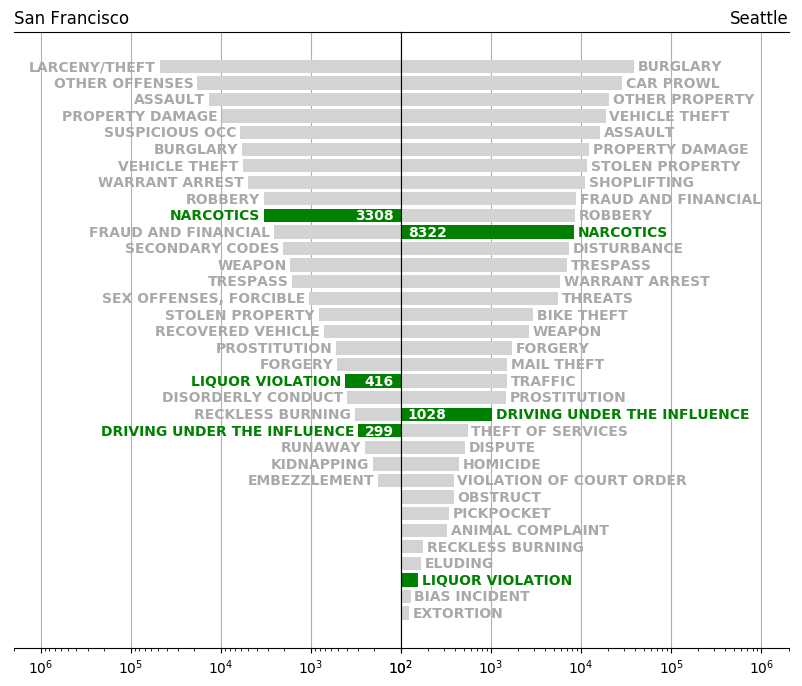

In [197]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(10,8))

for i in range(len(df_sea_stats) - len(df_sfo_stats)):
    df_sfo_stats.loc[len(df_sfo_stats)] = 0.0
    df_sfo_stats.index = df_sfo_stats.index[:-1].append(pd.Index(['']))   


df_sea_inv = df_sea_stats.iloc[::-1]
y_sea_pos = np.arange(len(df_sea_inv))

df_sfo_inv = df_sfo_stats.iloc[::-1]
y_sfo_pos = np.arange(len(df_sea_inv))

ax1.barh(y_sfo_pos, df_sfo_inv, align='center', color='lightgray') #, alpha=0.5)
ax2.barh(y_sea_pos, df_sea_inv, align='center', color='lightgray') #, alpha=0.5);



for s in ['LIQUOR VIOLATION', 'NARCOTICS', 'DRIVING UNDER THE INFLUENCE']:
    t = [i for i, x in enumerate(df_sfo_inv.index == s) if x]
    if len(t) > 0:
        ax1.patches[t[0]].set_facecolor('g')
    
for s in ['LIQUOR VIOLATION', 'NARCOTICS', 'DRIVING UNDER THE INFLUENCE']:
    t = [i for i, x in enumerate(df_sea_inv.index == s) if x]
    if len(t) > 0:
        ax2.patches[t[0]].set_facecolor('g')

    
#ax1.set_yticklabels()
#ax2.set_yticklabels()
ax1.set_xscale("log", nonposx='clip')
ax2.set_xscale("log", nonposx='clip')
ax1.set_xlim(left=100, right=2_000_000)
ax2.set_xlim(left=101, right=2_000_000)

ax1.invert_xaxis()

ax1.get_yaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
import numpy as np

for p, i, x in zip(y_sfo_pos, df_sfo_inv.index, df_sfo_inv):
    C = 'darkgray'
    if i in ['LIQUOR VIOLATION', 'NARCOTICS', 'DRIVING UNDER THE INFLUENCE']:
        C = 'green'
    
    ax1.text(x + x*.1, p -  0.25, str(i), color=C, fontweight='bold', horizontalalignment='right')
    if C == 'green' and x > 200:
        ax1.text(120, p -  0.25, str(int(x)), color='white', fontweight='bold', horizontalalignment='right')

        
    
    
    
for p, i, x in zip(y_sea_pos, df_sea_inv.index, df_sea_inv):
    C = 'darkgray'
    if i in ['LIQUOR VIOLATION', 'NARCOTICS', 'DRIVING UNDER THE INFLUENCE']:
        C = 'green'
    
    ax2.text(x + x*.1, p -  0.25, str(i), color=C, fontweight='bold', horizontalalignment='left')
    if C == 'green' and x > 200:
        ax2.text(120, p -  0.25, str(int(x)), color='white', fontweight='bold', horizontalalignment='left')




#plt.yticks(y_pos, df.index)
ax1.set_title('San Francisco', loc='left')
ax2.set_title('Seattle', loc='right');

ax1.set_axisbelow(True)
ax1.grid()
ax2.set_axisbelow(True)
ax2.grid()

ax1.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.subplots_adjust(wspace=0, hspace=0)
fig.savefig('crimes.png', dpi=300, bbox_inches = 'tight')


In [198]:
df_seattle3 = df_seattle2[['RMS CDW ID','datetime','Longitude','Latitude','offense']]
df_seattle3.columns = ['id', 'datetime', 'lon', 'lat', 'offense']
df_seattle3 = df_seattle3[df_seattle3.offense.isin(['LIQUOR VIOLATION', 'NARCOTICS', 'DRIVING UNDER THE INFLUENCE'])]

feather.write_dataframe(df_seattle3, 'seattle_drugs_2017.feather')
df_sanfrancisco3 = df_sanfrancisco2[['IncidntNum','datetime','X','Y','offense']]
df_sanfrancisco3.columns = ['id', 'datetime', 'lon', 'lat', 'offense']
df_sanfrancisco3 = df_sanfrancisco3[df_sanfrancisco3.offense.isin(['LIQUOR VIOLATION', 'NARCOTICS', 'DRIVING UNDER THE INFLUENCE'])]

feather.write_dataframe(df_sanfrancisco3, 'sanfrancisco_drugs_2017.feather')

# Time and Date of drug/alcohol-related offenses

In [107]:
df_seattle3 = feather.read_dataframe('seattle_drugs_2017.feather')
df_sanfrancisco3 = feather.read_dataframe('sanfrancisco_drugs_2017.feather')

In [108]:
df_seattle3['city'] = 'Seattle'
df_sanfrancisco3['city'] = 'SanFrancisco'
df = pd.concat((df_seattle3, df_sanfrancisco3))

In [109]:
from plotnine import *

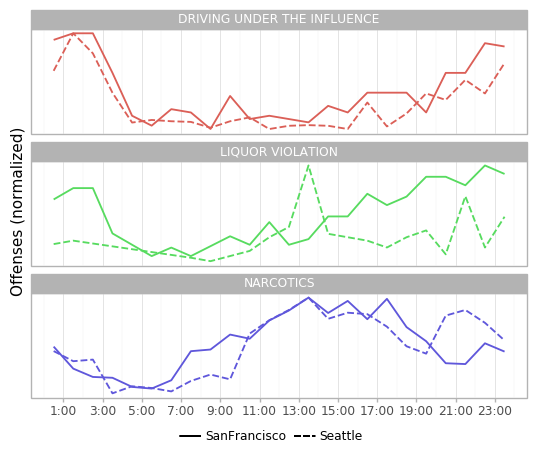

<ggplot: (320533638)>


In [199]:
df_ = df.groupby([df.datetime.dt.hour, df.city, df.offense]).size().reset_index(name='count')
df_['datetime'] += 0.5
df2_ = df_.copy(deep=True)

for o in ['LIQUOR VIOLATION', 'NARCOTICS', 'DRIVING UNDER THE INFLUENCE']:
    mask_sea = (df_.city == 'Seattle') & (df_.offense == o)
    mask_sfo = (df_.city == 'SanFrancisco') & (df_.offense == o)
    
    df_valid = df_[mask_sea]
    df2_.loc[mask_sea, 'count'] = df_valid['count'] / df_[mask_sea]['count'].max()
    
    df_valid = df_[mask_sfo]
    df2_.loc[mask_sfo, 'count'] = df_valid['count'] / df_[mask_sfo]['count'].max()

hours = [1,3,5,7,9,11,13,15,17,19,21,23]

    
p = ggplot(df2_) #df_, aes(x='datetime', y='count', group='offense'))
p = p + geom_line(aes(x='datetime', y='count', colour='offense', linetype='city'), size=.75)
p = p + ylab('Offenses (normalized)') + xlab('')
p = p + scale_x_continuous(breaks=hours, labels=[f'{a}:00' for a in hours]) + scale_color_discrete(guide=False) 
p = p + scale_y_continuous(breaks=[]) + scale_color_discrete(guide=False) 
p = p + facet_wrap('offense', ncol=1, scales='free_y', as_table=True)
p = p + guides(linetype=guide_legend(ncol=2))
p = p + theme_light() + theme(legend_key=element_blank(), legend_title=element_blank(), legend_position="bottom") 
print(p);
p.save(filename = 'hourly.png', height=5, width=7, units = 'in', dpi=300)

In [174]:
dfb = df.copy(deep=True)

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
holidays = cal.holidays(start=dfb.datetime.min().date(), end=dfb.datetime.max().date())

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_bd = CustomBusinessDay(calendar=cal)

all_days  = pd.date_range(dfb.datetime.min().date(), dfb.datetime.max().date())
work_days   = (pd.DatetimeIndex(start=dfb.datetime.min().date(),end=dfb.datetime.max().date(), freq=us_bd))
n_work_days = len(work_days)

def get_hrs(x):
    if x.dayofweek == 0:
        return 20
    elif x.dayofweek in [1,2,3,4]:
        return 24
    elif x.dayofweek == 5:
        return 20
    else:
        print('should not happen')
        return 1000000
    
hr_work_days = [get_hrs(x) for x in work_days]
hr_non_work_days = [24 for x in all_days if x not in work_days]

# extra
extra = sum([24-x for x in hr_work_days if x != 24])
print(extra)


print(len(hr_work_days), sum(hr_work_days))
print(len(hr_non_work_days), sum(hr_non_work_days)+extra)

# corrected wor/ non-work days
work_days = len(hr_work_days) * (sum(hr_work_days) / len(hr_work_days) / 24.)
non_work_days = len(hr_non_work_days) * ((sum(hr_non_work_days)+extra) / len(hr_non_work_days) / 24.)


#work_days = len(pd.DatetimeIndex(start=dfb.datetime.min().date(),end=dfb.datetime.max().date(), freq=us_bd))
#non_work_days = len(all_days) - work_days

def work_period(x):
    if x.dayofweek in [1,2,3]:
        if x.date in holidays:
            return 'Non-work'
        return 'Work'
    elif x.dayofweek == 0 and x.hour > 4:
        if x.date in holidays:
            return 'Non-work'
        return 'Work'
    elif x.dayofweek == 4 and x.hour < 20:
        if x.date in holidays:
            return 'Non-work'
        return 'Work'
    return 'Non-work'

def day_of_week(x):
    mapper = dict(zip(range(7), 'MO,TU,WE,TH,FR,SA,SU'.split(',')))
    return pd.Series(mapper[x.dayofweek], dtype='category')

def day_night(x):
    if (x.hour < 7) or (x.hour > 21):
        return 'Night'
    return 'Day'

dfb['work'] = dfb['datetime'].apply(work_period)
dfb['dow']  = dfb['datetime'].apply(day_of_week)
dfb['dn']   = dfb['datetime'].apply(day_night)

dfb['dow'] = dfb['dow'].astype('category')
dfb['dow'].cat.reorder_categories(['MO','TU','WE','TH','FR','SA','SU'], inplace=True)

dfb['work'] = dfb['work'].astype('category')
dfb['work'].cat.reorder_categories(['Work','Non-work'], inplace=True)


180
250 5820
115 2940


In [175]:
dfb.head(3)

,id,datetime,lon,lat,offense,city,work,dow,dn
0,1249819,2017-08-02 21:07:00,-122.302711,47.612942,DRIVING UNDER THE INFLUENCE,Seattle,Work,WE,Day
1,1263009,2017-05-14 00:59:00,-122.333809,47.612103,NARCOTICS,Seattle,Non-work,SU,Night
2,1263011,2017-05-18 10:31:00,-122.324615,47.708603,NARCOTICS,Seattle,Work,TH,Day


In [176]:
dfd = dfb.groupby([dfb.work, dfb.city, dfb.offense]).size().reset_index(name='count')
dfd['count_norm'] = dfd['count']
mask_work = dfd.work == 'Work'

df_valid = dfd[mask_work]
df_valid2 = dfd[~mask_work]

dfd.loc[mask_work, 'class_days']  = work_days
dfd.loc[~mask_work, 'class_days'] = non_work_days
dfd['count_norm'] = dfd['count'] / dfd.class_days
dfd

,work,city,offense,count,count_norm,class_days
0,Work,SanFrancisco,DRIVING UNDER THE INFLUENCE,130,0.536082,242.5
1,Work,SanFrancisco,LIQUOR VIOLATION,196,0.808247,242.5
2,Work,SanFrancisco,NARCOTICS,2413,9.950515,242.5
3,Work,Seattle,DRIVING UNDER THE INFLUENCE,570,2.350515,242.5
4,Work,Seattle,LIQUOR VIOLATION,91,0.375258,242.5
5,Work,Seattle,NARCOTICS,5926,24.437113,242.5
6,Non-work,SanFrancisco,DRIVING UNDER THE INFLUENCE,169,1.379592,122.5
7,Non-work,SanFrancisco,LIQUOR VIOLATION,220,1.795918,122.5
8,Non-work,SanFrancisco,NARCOTICS,895,7.306122,122.5
9,Non-work,Seattle,DRIVING UNDER THE INFLUENCE,458,3.738776,122.5


In [177]:
#dfd2 = dfd.copy(deep=True)

dfd.loc[dfd.offense == 'NARCOTICS', 'count_norm'] = dfd['count_norm'] / 10
dfd.loc[dfd.offense == 'NARCOTICS', 'offense'] = 'NARCOTICS (* 0.1)'

# narcotics divided by 10

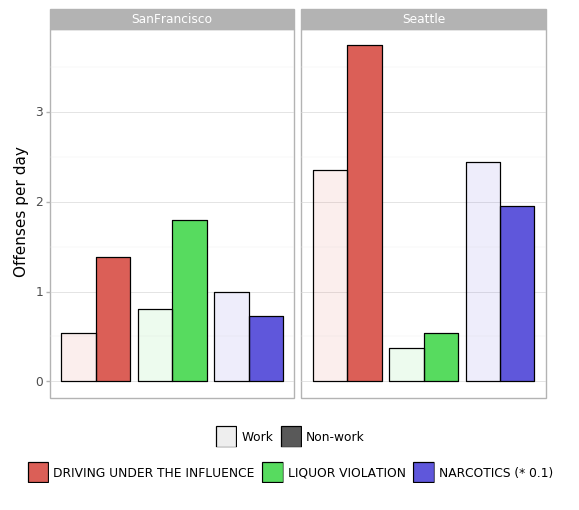

<ggplot: (-9223372036532192445)>


In [178]:
p = ggplot(dfd, aes(x='offense', y='count_norm', group='work', fill='offense'))
p = p + geom_bar(aes(alpha='work'), stat='identity', position='dodge', color='black')
p = p + ylab('Offenses per day') + xlab('')
#p = p + ylab('Offenses (normalized)') + xlab('')
p = p + scale_x_discrete(breaks=[]) + scale_color_discrete(guide=False) 
p = p + facet_wrap('city', ncol=2, as_table=True)
#p = p + guides(linetype=guide_legend(ncol=2))
p = p + theme_light() + theme(legend_key=element_blank(), legend_title=element_blank(), legend_position="bottom") 
print(p)
p.save(filename = 'workdays.png', height=5, width=5, units = 'in', dpi=300)

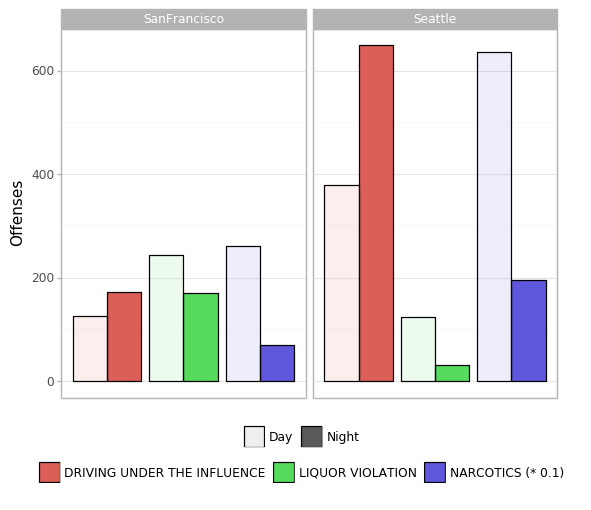

<ggplot: (321105791)>


In [179]:
dfb_dn = dfb.groupby([dfb.dn, dfb.city, dfb.offense]).size().reset_index(name='count')

df_valid = dfb_dn[dfb_dn.offense == 'NARCOTICS']
dfb_dn.loc[dfb_dn.offense == 'NARCOTICS', 'count'] = df_valid['count'] / 10
dfb_dn.loc[dfb_dn.offense == 'NARCOTICS', 'offense'] = 'NARCOTICS (* 0.1)'


p = ggplot(dfb_dn, aes(x='offense', y='count', group='dn', fill='offense'))
p = p + geom_bar(aes(alpha='dn'), stat='identity', position='dodge', color='black')
p = p + ylab('Offenses') + xlab('')
#p = p + ylab('Offenses (normalized)') + xlab('')
p = p + scale_x_discrete(breaks=[]) + scale_color_discrete(guide=False) 
p = p + facet_wrap('city', ncol=2, as_table=True)
#p = p + guides(linetype=guide_legend(ncol=2))
p = p + theme_light() + theme(legend_key=element_blank(), legend_title=element_blank(), legend_position="bottom") 
print(p)
p.save(filename = 'daynight.png', height=5, width=5, units = 'in', dpi=300)

<class 'pandas.core.series.Series'>


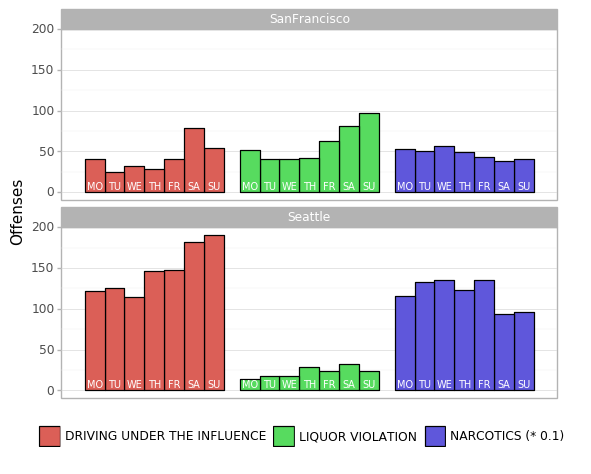

<ggplot: (283910320)>


In [181]:
dfb_dow = dfb.groupby([dfb.dow, dfb.city, dfb.offense]).size().reset_index(name='count')
print(type(dfb_dow.dow))
df_valid = dfb_dow[dfb_dow.offense == 'NARCOTICS']
dfb_dow.loc[dfb_dow.offense == 'NARCOTICS', 'count'] = df_valid['count'] / 10
dfb_dow.loc[dfb_dow.offense == 'NARCOTICS', 'offense'] = 'NARCOTICS (* 0.1)'


p = ggplot(dfb_dow, aes(x='offense', y='count', group='dow', fill='offense'))
p = p + geom_bar(stat='identity', position='dodge', color='black')
p = p + geom_text(aes(x='offense', y=7, label='dow', group='dow'), position=position_dodge(width = .9), size=7, colour='white')
p = p + ylab('Offenses') + xlab('')
#p = p + ylab('Offenses (normalized)') + xlab('')
p = p + scale_x_discrete(breaks=[]) + scale_color_discrete(guide=False) 
p = p + facet_wrap('city', ncol=1, as_table=True)
#p = p + guides(linetype=guide_legend(ncol=2))
p = p + theme_light() + theme(legend_key=element_blank(), legend_title=element_blank(), legend_position="bottom") 
print(p)
p.save(filename = 'weekday.png', height=5, width=5, units = 'in', dpi=300)

# Plotting

In [28]:
# plotting
import pylab
import matplotlib.pylab as plt
# add some nice background for maps
import contextily as ctx
# geo imports
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pyproj
import shapely
shapely.speedups.enable()

In [29]:
OFFENSES=['DRIVING UNDER THE INFLUENCE','LIQUOR VIOLATION', 'NARCOTICS']

In [40]:
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png', city=None, focus=None):
    xmin, xmax, ymin, ymax = ax.axis()
    #print(xmin, xmax, ymin, ymax)
    #-13638612.871751599 -13620865.745119028 4538276.875422169 4553254.237254951
    if city== 'SanFrancisco':
        xmin, xmax, ymin, ymax = (-13635000, -13620000, 4540276, 4553254)
        if focus:
            xmin, xmax, ymin, ymax = (-13630000, -13625000, 4545500, 4550500)
    if city == 'Seattle':
        xmin, xmax, ymin, ymax = (-13625417, -13609507, 6022150, 6059758)
        if focus:
            xmin, xmax, ymin, ymax = (-13625417, -13609507, 6032150, 6049758)
        
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

In [31]:
# convert to geopandas 
gf = gpd.GeoDataFrame(dfb.drop(['lon', 'lat'], axis=1),
                      crs={'init': 'epsg:4326'},
                      geometry=[shapely.geometry.Point(xy) for xy in zip(dfb.lon, dfb.lat)])
gf.head() #gf = gf.rename(columns={'geometry': 'pickup'})

,id,datetime,offense,city,work,dow,dn,geometry
0,1249819,2017-08-02 21:07:00,DRIVING UNDER THE INFLUENCE,Seattle,Work,WE,Day,POINT (-122.302711487 47.612941742)
1,1263009,2017-05-14 00:59:00,NARCOTICS,Seattle,Non-work,SU,Night,POINT (-122.333808899 47.612102509)
2,1263011,2017-05-18 10:31:00,NARCOTICS,Seattle,Work,TH,Day,POINT (-122.324615479 47.708602905)
3,1263814,2017-08-14 14:39:00,NARCOTICS,Seattle,Work,MO,Day,POINT (-122.344894409 47.71717453)
4,1420311,2017-11-27 20:39:00,NARCOTICS,Seattle,Work,MO,Day,POINT (-122.312683105 47.719413757)


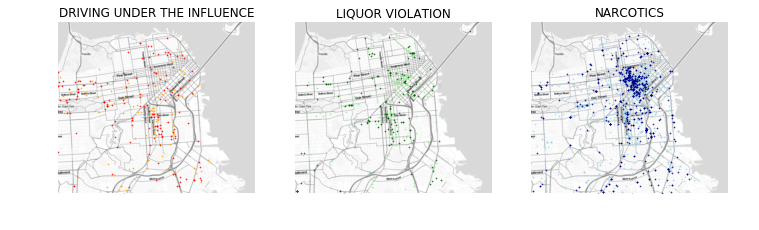

In [62]:
city='SanFrancisco'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
axes = axes.flatten()
for i, (c1, c2, o) in enumerate(zip(['orange','lightgreen','lightblue'], ['red','darkgreen','darkblue'], OFFENSES)):
    gf[(gf.city==city)&(gf.offense==o)&(gf.dn=='Day')].to_crs(epsg=3857).plot(ax=axes[i], color=c1, alpha=.75, markersize=.5)
    gf[(gf.city==city)&(gf.offense==o)&(gf.dn=='Night')].to_crs(epsg=3857).plot(ax=axes[i], color=c2, alpha=.75, markersize=.5)
    add_basemap(axes[i], zoom=13, url=ctx.sources.ST_TONER_LITE, city=city)
    axes[i].set_axis_off()
    axes[i].set_title(OFFENSES[i])
fig.savefig('sanfrancisco_map.png', dpi=300, bbox_inches = 'tight')

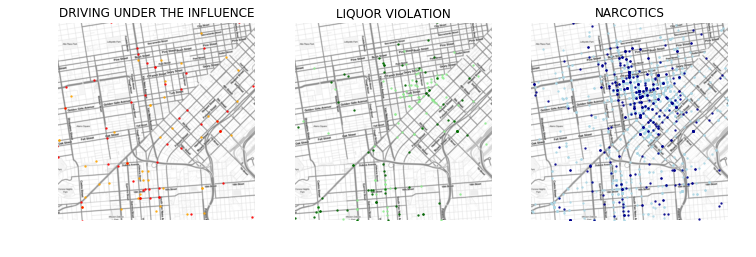

In [86]:
city='SanFrancisco'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,8))
axes = axes.flatten()
for i, (c1, c2, o) in enumerate(zip(['orange','lightgreen','lightblue'], ['red','darkgreen','darkblue'], OFFENSES)):
    gf[(gf.city==city)&(gf.offense==o)&(gf.dn=='Day')].to_crs(epsg=3857).plot(ax=axes[i], color=c1, alpha=.75, markersize=2)
    gf[(gf.city==city)&(gf.offense==o)&(gf.dn=='Night')].to_crs(epsg=3857).plot(ax=axes[i], color=c2, alpha=.75, markersize=2)
    add_basemap(axes[i], zoom=15, url=ctx.sources.ST_TONER_LITE, city=city, focus=True)
    axes[i].set_axis_off()
    axes[i].set_title(OFFENSES[i])
fig.savefig('sanfrancisco_map_cbd.png', dpi=300, bbox_inches = 'tight')

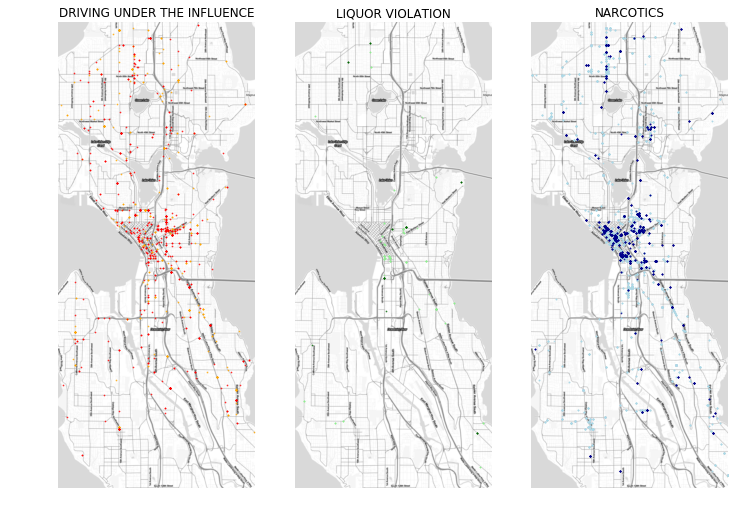

In [64]:
city='Seattle'
# pickup and dropoff plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,10))
axes = axes.flatten()
for i, (c1, c2, o) in enumerate(zip(['orange','lightgreen','lightblue'], ['red','darkgreen','darkblue'], OFFENSES)):
    gf[(gf.city==city)&(gf.offense==o)&(gf.dn=='Day')].to_crs(epsg=3857).plot(ax=axes[i], color=c1, alpha=.75, markersize=.5)
    gf[(gf.city==city)&(gf.offense==o)&(gf.dn=='Night')].to_crs(epsg=3857).plot(ax=axes[i], color=c2, alpha=.75, markersize=.5)
    add_basemap(axes[i], zoom=13, url=ctx.sources.ST_TONER_LITE, city=city)
    axes[i].set_axis_off()
    axes[i].set_title(OFFENSES[i])
fig.savefig('seattle_map.png', dpi=300, bbox_inches = 'tight')

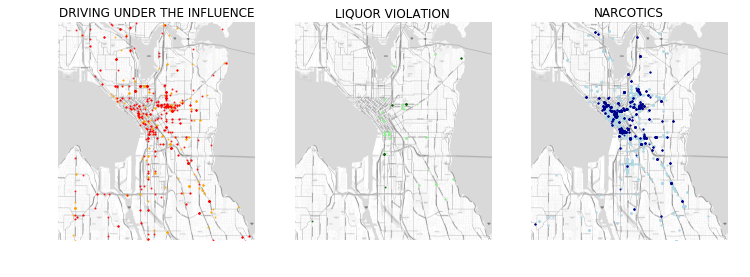

In [65]:
city='Seattle'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
axes = axes.flatten()
for i, (c1, c2, o) in enumerate(zip(['orange','lightgreen','lightblue'], ['red','darkgreen','darkblue'], OFFENSES)):
    gf[(gf.city==city)&(gf.offense==o)&(gf.dn=='Day')].to_crs(epsg=3857).plot(ax=axes[i], color=c1, alpha=.75, markersize=1)
    gf[(gf.city==city)&(gf.offense==o)&(gf.dn=='Night')].to_crs(epsg=3857).plot(ax=axes[i], color=c2, alpha=.75, markersize=1)
    add_basemap(axes[i], zoom=15, url=ctx.sources.ST_TONER_LITE, city=city, focus=True)
    axes[i].set_axis_off()
    axes[i].set_title(OFFENSES[i])
fig.savefig('seattle_map_cbd.png', dpi=300, bbox_inches = 'tight')